<a href="https://colab.research.google.com/github/FaisalAhmed0/machine_learning_from_scratch/blob/main/Linear_regression_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression
This notebook contains an implementaion of Linear Regression algorithm using numpy.

# Imports and functions defenitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
def plot(x, y, title=None, xlabel=None, ylabel=None, plot_type="scatter"):
  '''
  plot(x, y, title=None, xlabel=None, ylabel=None, plot_type="scatter")
  simple helper function to plot data.
  parameters
  x: x-axis data.
  y: y-axis data.
  title: figure title.
  xlabel: x-axis label.
  ylabel: y-axis label.
  plot_type: if "scatter" the plot will be scatter otherwise, it will plot a line plot
  '''
  if plot_type == "scatter":
    plt.scatter(x, y)
  else:
    plt.plot(x, y)
  if xlabel:
    plt.xlabel(xlabel)
  if ylabel:
    plt.ylabel(ylabel)
  if title:
    plt.title(title)

In [3]:
def generate_synthetic_data(size=100, plot_data=False, function=None, data_var = 100, outliers_var = 100):
  '''
  generate_synthetic_data(size=100, plot_data=False)
  This function generate fake data to check the implementation of linear regression
  size: number of example
  plot_data: if True, the generated data will be plotted
  '''
  slope = 50
  intercept = 2
  x = np.linspace(-10, 10, size)
  if function:
    y = function(x) + (data_var * np.random.randn(size))
  else:
    y = (slope * x + intercept) + (data_var * np.random.randn(size))
  # make some outliers
  y[list(range(0, size, size//5))] = x[list(range(0, size, size//5))]**3 + (outliers_var * np.random.randn(len(list(range(0, size, size//5)))))
  if plot_data:
    plot(x, y, "Training data", "x", "y")
  return x, y

In [4]:
def split_valid(X, Y, split_ratio=0.2):
  '''
  split_valid(X, Y, split_ratio=0.2)
  X: The input features.
  Y: The target output.
  split_ratio: ratio of the validation set size.
  return:
  tuple contains x_train, y_train, x_valid, y_valid
  '''
  if split_ratio == 0:
    return X, Y, None, None
  data_size = X.shape[0]
  valid_length = int(data_size * split_ratio)
  # shuffle the data before splitting
  inds = np.random.choice(range(data_size), data_size, replace=False)
  # print(inds)
  X = X[inds]
  Y = Y[inds]

  x_valid = X[: valid_length]
  y_valid = Y[: valid_length]

  x_train = X[valid_length: ]
  y_train = Y[valid_length: ]
  return x_train, y_train, x_valid, y_valid

In [5]:
def poly_features(x, degree=2):
  '''
  poly_features(x, degree=2)
  Add polynomial features to the x input
  x: a 1D numpy vector represnts the original input
  degree: degree of the polynmoial
  return:
  a numpy array of shape (N, degrees), where N is the size of the dataset
  '''
  poly = [x.copy()]
  for i in range(2, degree+1):
    poly.append(x**i)
  return np.array(poly).T

# Data Generation

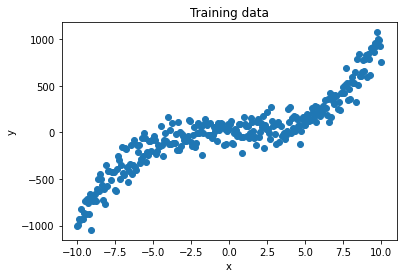

In [6]:
# generate the data and make copy 
function = lambda x: x**3 
x, y = generate_synthetic_data(300, True, outliers_var=0, function=function)
x_original = x.copy()

In [9]:
x = poly_features(x, 3)

# Model definition and training

In [10]:
class LinearRegression:
  '''
  This class implements simple linear regression
  Constructor:
  lr: learning rate
  epochs: number of training epochs
  solver: either "exact" for exact least squares solution or "sgd" for mini_batch gradient descent
  '''
  def __init__(self, lr=0.1, epochs=100, solver='sgd'):
    self.lr = lr
    self.epochs = epochs
    self.solver = solver
    self.theta = None
  
  def _least_squares(self, X, Y, X_valid=None, Y_valid=None):
    '''
    X: input matrix (Design matrix) of the shape (N, D), where N is the number of example, D is the input dimension (number of features)
    Y: the ground truth for each example shape: (N, )
    '''
    theta = np.linalg.solve(X.T @ X, X.T @ Y)
    self.theta = theta
    return theta

  def _sgd(self, X, Y , X_valid=None, Y_valid=None, mini_batch_size=1, options=None):
    '''
    X: input matrix (Design matrix) of the shape (N, D), where N is the number of example, D is the input dimension (number of features)
    Y: the ground truth for each example shape: (N, )
    mini_batch_size: size of the sample during each training iteration if mini_batch_size == batch_size then its a full batch gradient descent
    '''
    data_size = X.shape[0]
    print(data_size)
    # print(f"batch size {batch_size}")
    input_dim = X.shape[1]
    theta = np.random.randn(input_dim,)
    b = 0
    n_iteration = data_size // mini_batch_size if data_size % mini_batch_size == 0 else data_size // mini_batch_size + 1
    loop = tqdm.tqdm_notebook(range(self.epochs))
    losses = []
    val_losses = []
    # for each pass through the data
    for epoch in loop:
      # shuffle the data
      inds = np.random.choice(range(data_size), data_size, replace=False)
      X = X[inds]
      Y = Y[inds]
      loss = 0
      for iter in range(n_iteration):
        start = iter*mini_batch_size 
        end = (iter+1)*mini_batch_size if (iter+1)*mini_batch_size < data_size else data_size
        # print(start, end)
        x_iter = X[start : end]
        y_iter = Y[start : end]
        grad_theta = (2/mini_batch_size) * (x_iter.T @ x_iter @ theta - x_iter.T @ y_iter)
        # print(grad_theta.shape)
        grad_b = (2/mini_batch_size) * np.sum(x_iter @ theta - y_iter)
        theta -= self.lr * grad_theta
        b -= self.lr * grad_b

        loss += np.mean( (y_iter -  x_iter @ theta)**2)
      loss /= n_iteration
      loop.set_description("Loss %0.3f" %loss)
      losses.append(loss)
      if not (X_valid is None and Y_valid is None):
        if options:
          x_mean = options['x_mean']
          x_std =  options['x_std']
          y_mean = options['y_mean']
          y_std =  options['y_std']
        else:
          x_mean = 0
          x_std =  1
          y_mean = 0
          y_std =  1
        x_stand = (X_valid - x_mean) / x_std
        preds = x_stand @ theta
        y_valid_stand = (Y_valid - y_mean) / y_std
        loss = np.mean((y_valid_stand - preds  )**2)
        val_losses.append(loss)
    self.theta = theta
    self.b = b
    return losses, val_losses

  def fit(self, X, Y, X_valid=None, Y_valid=None , mini_batch_size=1, options=None):
    if self.solver == "exact":
      self._least_squares(X, Y)
    else:
      losses, val_losses = self._sgd(X, Y, mini_batch_size=mini_batch_size, options=options, X_valid=X_valid, Y_valid=Y_valid)
      return losses, val_losses

  def predict(self, x):
    assert not self.theta is None, "Model is not fitted"
    # print(self.b)
    return x @ self.theta + self.b

In [12]:
if len(x.shape) == 1:
  x = x.reshape(-1, 1)
model = LinearRegression(solver="sgd", lr=1e-3, epochs=500)
# split the data
x_train, y_train, x_valid, y_valid = split_valid(x, y, 0)
# normalize the input
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
x_stand = (x_train - x_mean) / x_std

y_mean = y_train.mean()
y_std = y_train.std()
y_stand = (y_train - y_mean) / y_std

options = {}
options['x_mean'] = x_mean
options['x_std'] = x_std
options['y_mean'] = y_mean
options['y_std'] = y_std

loss, val_loss = model.fit(x_stand, y_stand,X_valid=x_valid, Y_valid=y_valid  ,mini_batch_size=1, options=options)

300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


# Results Visulization

In [13]:
# function to visulaize the training output
def visualize_results(model, input, target, options=None, title=None):
  if options:
    x_mean = options['x_mean']
    x_std =  options['x_std']
    y_mean = options['y_mean']
    y_std =  options['y_std']
    x_stand = (input - x_mean) / x_std
    preds = model.predict(x_stand)
    preds = (preds * y_std) + y_mean
  else:
    preds = model.predict(input)
  plt.figure(figsize=(10, 5))
  plt.plot(input[:, 0], preds, label="Predictions", c="g")
  plt.scatter(input[:, 0], target, label="Ground truth")
  plt.xlabel("x")
  plt.ylabel("y")
  if title:
    plt.title(title)
  plt.legend()

In [14]:
def plot_loss(loss, val_loss=None, title=None):
  plt.figure(figsize=(10, 5))
  epochs = range(1, len(loss)+1 )
  plt.plot(epochs, loss, label="Training loss")
  if val_loss:
    plt.plot(epochs, val_loss, label="Validation loss")
  plt.xlabel("epoch")
  plt.ylabel("Loss")
  if title:
    plt.title(title)
  else:
    plt.title("Loss per epoch")
  plt.legend()

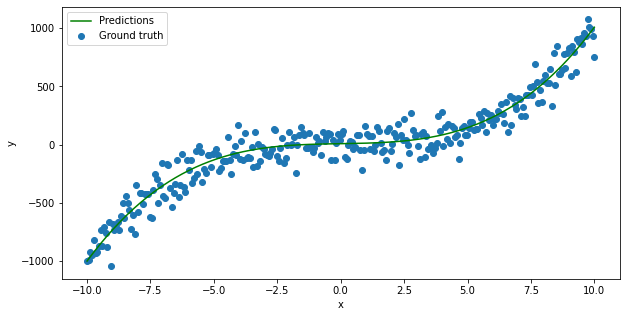

In [15]:
# plot the model predictions and compare it with ground truth
visualize_results(model, x, y, options=options)

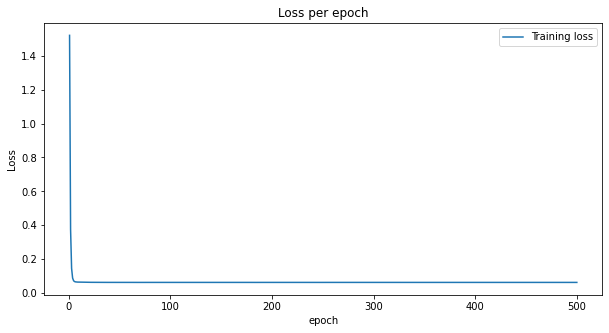

In [16]:
# plot the loss to see the training dynamics 
plot_loss(loss, val_loss)

# Overfitting demo

######################  Degress = 3  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



######################  Degress = 4  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



######################  Degress = 6  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



######################  Degress = 10  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



######################  Degress = 30  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



######################  Degress = 50  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



######################  Degress = 70  ######################
300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


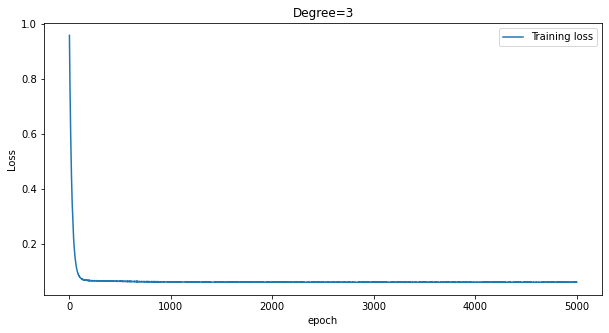

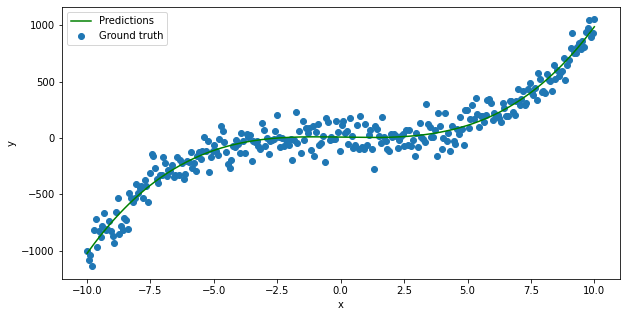

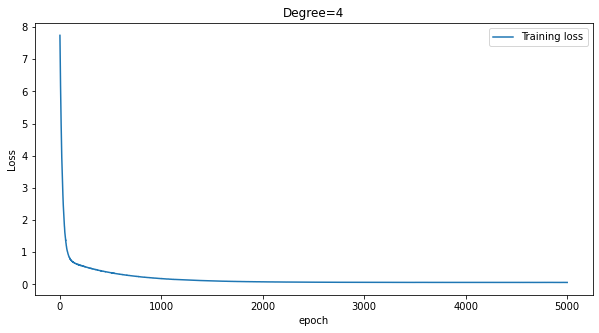

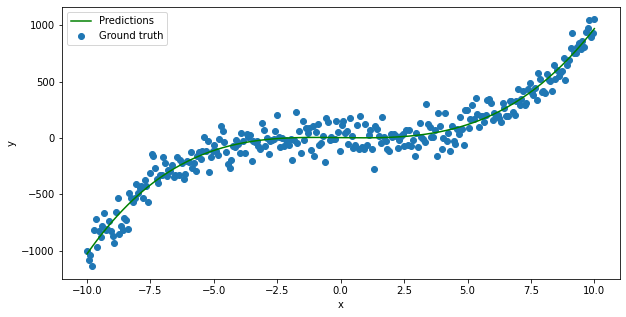

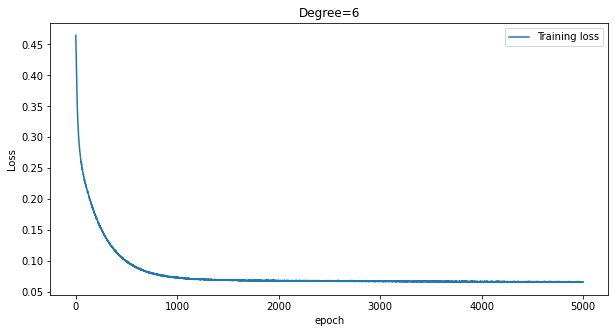

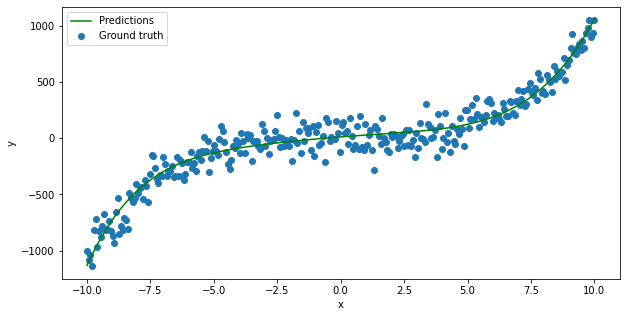

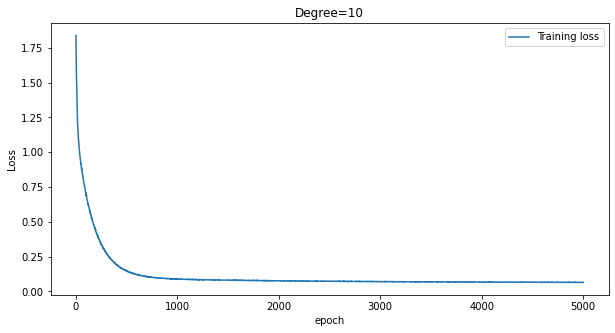

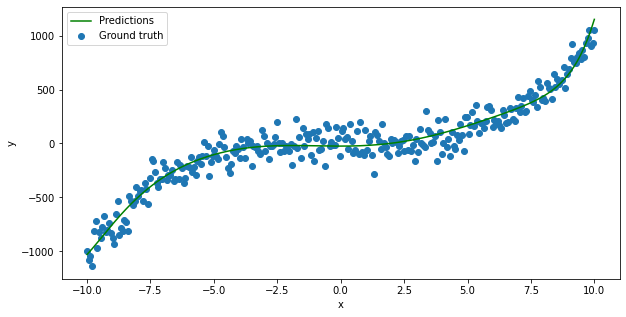

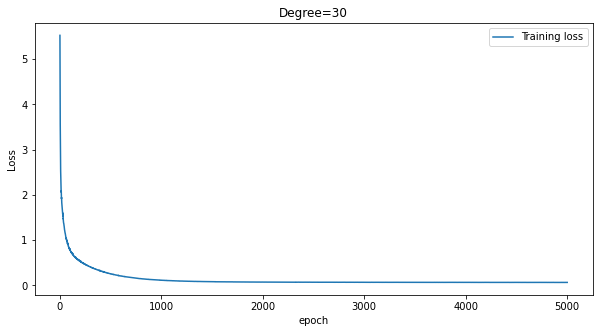

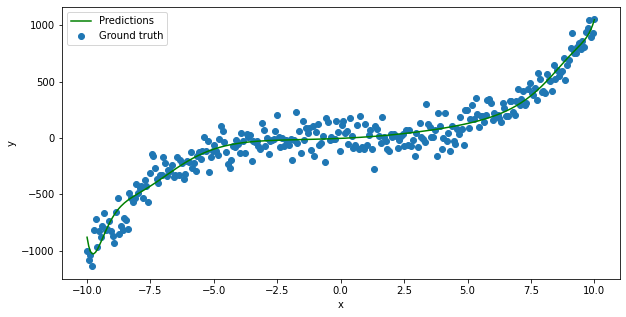

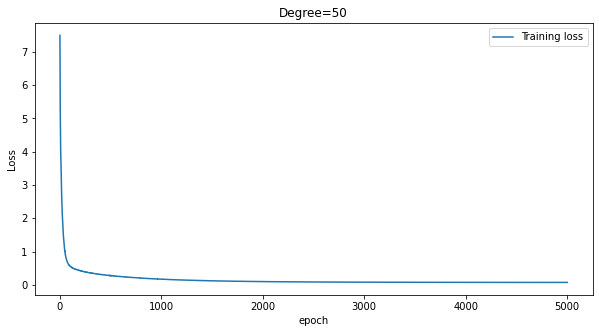

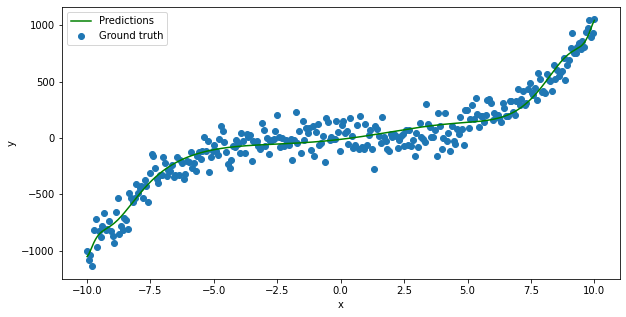

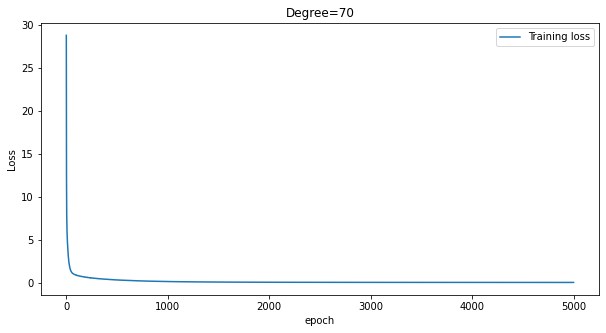

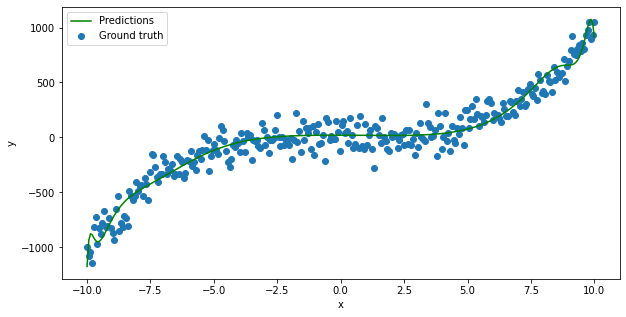

In [208]:
# let us see what happen when the polynoial degree is high, so we can observe some overfitting.
degrees = [3, 4, 6, 10, 30, 50, 70] 
for degree in degrees:
  x_poly = poly_features(x, degree)
  # print(x.shape)
  model = LinearRegression(epochs=5000, lr=3e-4, solver='sgd')
  x_train, y_train, x_valid, y_valid = split_valid(x_poly, y, 0)
  # print(x_poly.shape)
  # normalize the input
  x_mean = x_train.mean(axis=0)
  # print(x_mean.shape)
  x_std = x_train.std(axis=0)
  x_stand = (x_train - x_mean) / x_std

  y_mean = y_train.mean()
  y_std = y_train.std()
  y_stand = (y_train - y_mean) / y_std

  options = {}
  options['x_mean'] = x_mean
  options['x_std'] = x_std
  options['y_mean'] = y_mean
  options['y_std'] = y_std
  print(f"######################  Degress = {degree}  ######################")
  loss, val_loss = model.fit(x_stand, y_stand,X_valid=x_valid, Y_valid=y_valid  ,mini_batch_size=16, options=options)
  plot_loss(loss, val_loss, title=f"Degree={degree}")
  visualize_results(model, x_poly, y, options)